## Simple Network

In [68]:
import numpy as np
from IPython.display import Image, display, Math, Latex

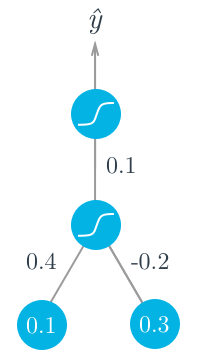

In [69]:
Image('simple_nn.png')

The input into the hidden unit is the sum of the weights times input plus bias:

$$\sum_{i} w_ix_i + b$$

The output of the hidden unit is put through the activation function, which in this case is the sigmoid function:

$$sigmoid(x)=1/(1+e^{-x})$$

$$sigmoid(\sum_{i} w_ix_i + b)$$


The output of the network is hidden unit output times the hidden layer weights:

$$0.1 * sigmoid(\sum_{i} w_ix_i + b)$$

In [71]:
"""
Working through an example
Let's walk through calculating the weights steps for a simple three layer network. 
Suppose there's two input units, one hidden unit, and one output unit, 
with sigmoid activations on the hidden and output units.
"""
def sigmoid(x):
    return 1/(1+(np.exp(-x)))

x = np.array([0.1, 0.3])

target = 1
learnrate = 0.5

weights_input_hidden = np.array([0.4, -0.2])

weights_hidden_output = np.array([0.1])


# calculate input to the hidden unit
hidden_layer_input = np.dot(x, weights_input_hidden)

#calculate the output of the hidden unit
hidden_layer_output = sigmoid(hidden_layer_input)

# calculate the output of the network
# sigmoid(0.1×0.495)=0.512.

output = sigmoid(weights_hidden_output*hidden_layer_output)

# calculate the error of the output unit
# (1−0.512)×0.512×(1−0.512)=0.122.

error = (target - output) * output * (target - output)

# calculate the error for the hidden unit with backpropagation
# 0.1×0.122×0.495×(1−0.495)=0.003

hidden_unit_error = weights_hidden_output * error * hidden_layer_output * (target - hidden_layer_output)

# calculate the gradient 
# 0.5×0.122×0.495=0.032

W = learnrate * error * hidden_layer_output

# calculate input to hidden weights

learnrate * hidden_unit_error * x[:, None]

array([[ 0.00015228],
       [ 0.00045683]])

# Neural Network from Scratch

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [11]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [12]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

In [13]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [14]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [15]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [16]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [17]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        print("weights_input_to_hidden shape: ", self.weights_input_to_hidden.shape)
        print("weights_hidden_to_output: ", self.weights_hidden_to_output.shape)

        # Activation function is the sigmoid function
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        

    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        
        # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        
        #final_outputs = self.activation_function(final_inputs)
        # regression program; therefore activation not needed
        final_outputs = final_inputs

        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # Output error
        output_errors = targets - final_outputs# Output layer error is the difference between desired target and actual output.
        
        """
        # TODO: Backpropagated error
        #hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)  # errors propagated to the hidden layer
        #hidden_grad = hidden_outputs * (1 - hidden_outputs)# hidden layer gradients
        """  
        
        # hidden error np.dot(self.weights_hidden_to_output.T, output_errors) * hidden_outputs * (1 - hidden_outputs)
        # I prefer including the error in the error gradient of the hidden layer
        hidden_error = np.dot(self.weights_hidden_to_output.T, output_errors) * hidden_outputs * (1 - hidden_outputs)

        # Update the weights
        self.weights_hidden_to_output += self.lr * output_errors * hidden_outputs.T# update hidden-to-output weights with gradient descent step
        #self.weights_input_to_hidden += self.lr * np.dot((hidden_errors * hidden_grad), inputs.T)# update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_error, inputs.T)
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer

        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        
        # regression model does not need activation function on final outputs
        final_outputs = final_inputs# signals from final output layer 
        return final_outputs

In [18]:
### Set the hyperparameters here ###
epochs = 3000
learning_rate = 0.01
hidden_nodes = 100
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']): 
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

('weights_input_to_hidden shape: ', (100, 56))
('weights_hidden_to_output: ', (1, 100))
Progress: 99.9% ... Training loss: 0.053 ... Validation loss: 0.146

(0.0, 0.5)

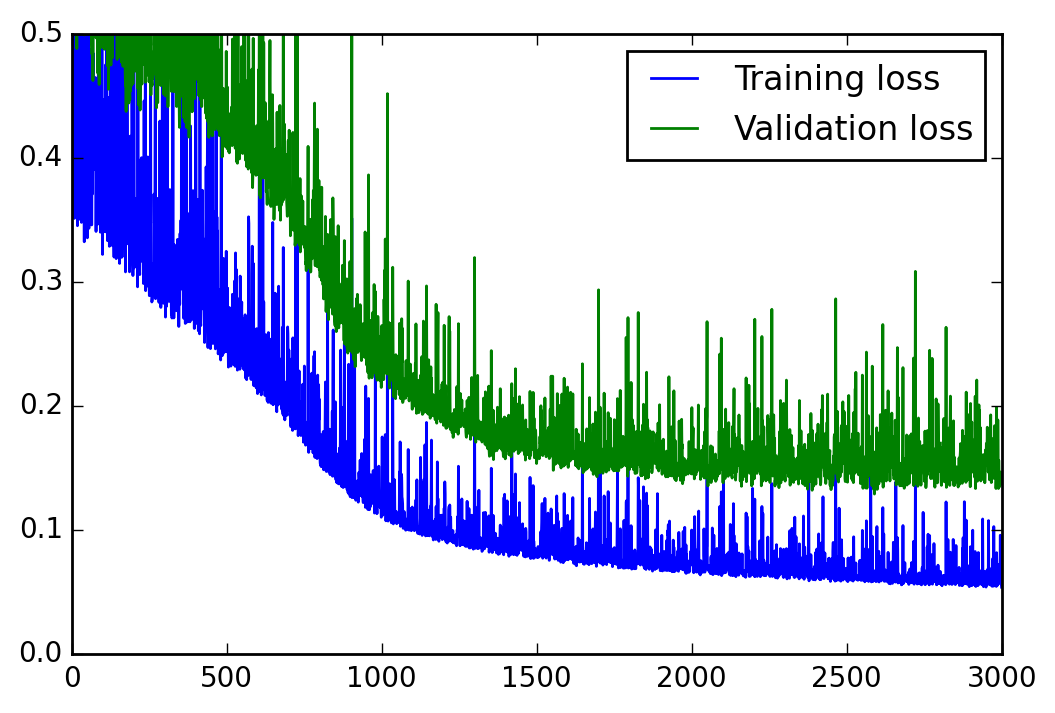

In [19]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)